Loading model from mobilenet_v3.pth


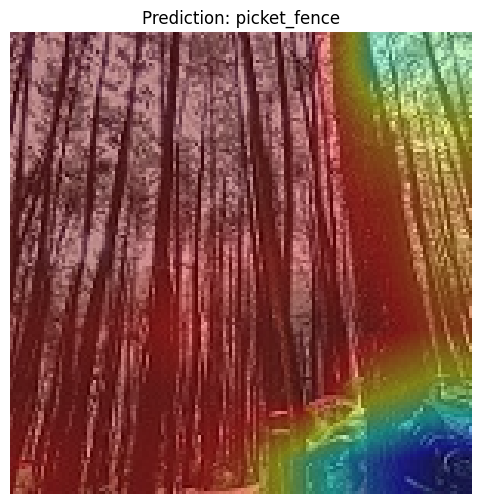

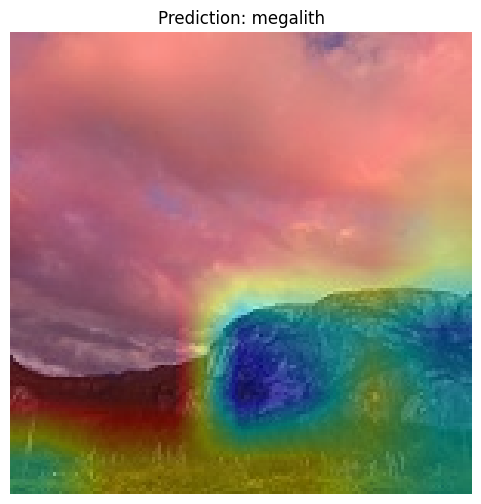

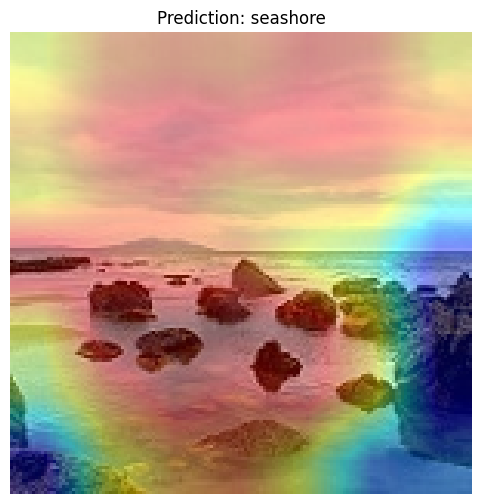

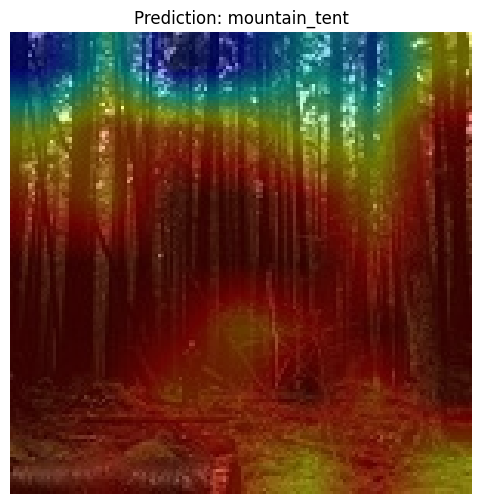

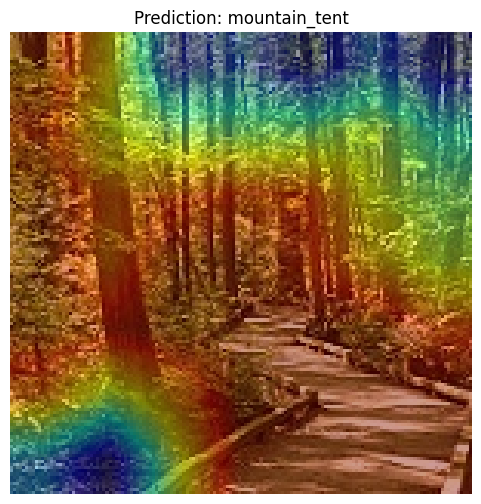

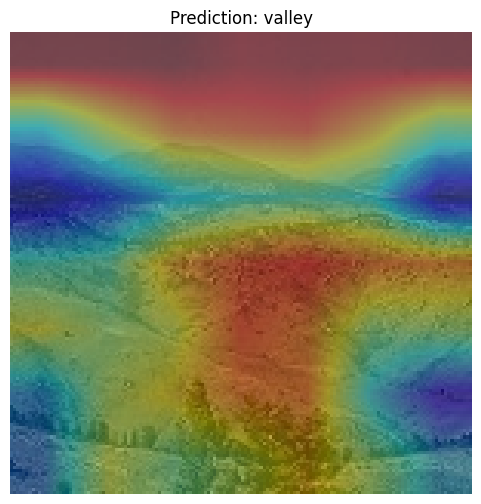

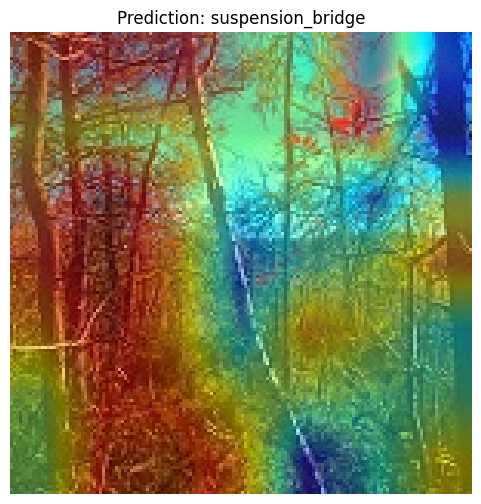

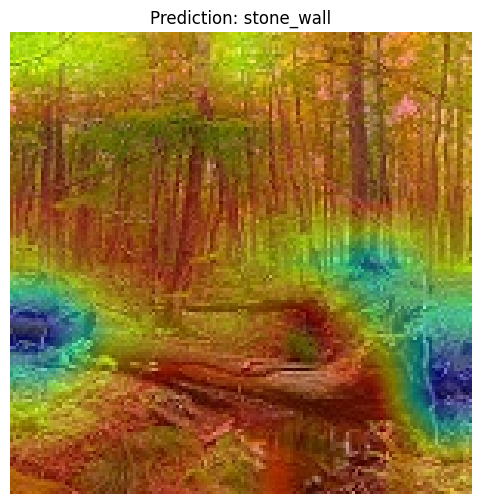

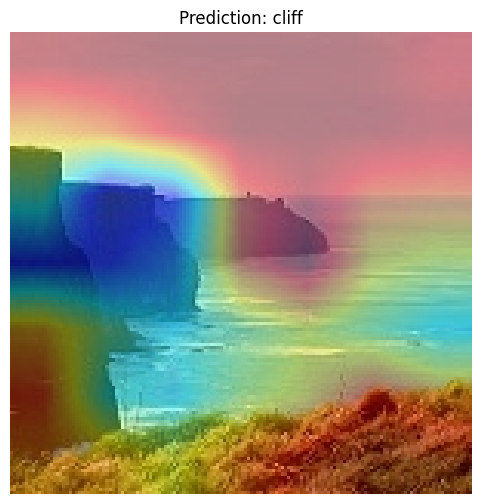

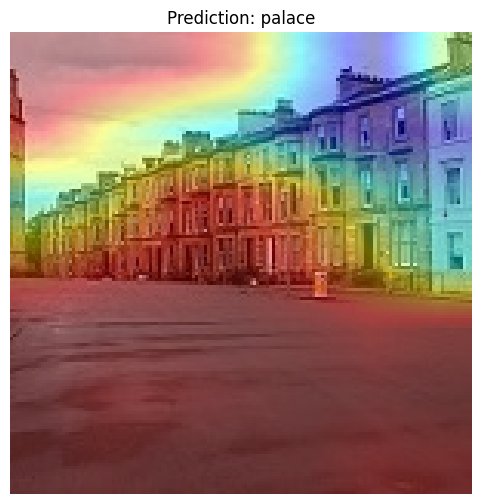

In [3]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os
import random
from PIL import Image

# Load MobileNetV3 Model
model_path = "mobilenet_v3.pth"
model = None
if os.path.exists(model_path): 
    print(f"Loading model from {model_path}")
    model = models.mobilenet_v3_large()
    model.load_state_dict(torch.load(model_path))
else:
    print(f"Model file not found. Downloading pretrained MobileNetV3.")
    model = models.mobilenet_v3_large(pretrained=True)
    torch.save(model.state_dict(), model_path)

model.eval()

# Get the last convolutional layer
final_conv_layer = model.features[-1]  # Last Conv Layer of MobileNetV3
activations = None
gradients = None

# Forward hook to store feature maps
def forward_hook(module, input, output):
    global activations
    activations = output  # Store activations

# Backward hook to store gradients
def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]  # Store gradients

# Register hooks
final_conv_layer.register_forward_hook(forward_hook)
final_conv_layer.register_full_backward_hook(backward_hook)  # Updated method

# Load ImageNet class index
local_class_idx_path = "imagenet_class_index.json"  
with open(local_class_idx_path, 'r') as f:
    class_idx = json.load(f)

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Select random images
image_dir = "../images/"
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
selected_images = random.sample(image_paths, 10)

for image_path in selected_images:
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Forward pass
    model.zero_grad()
    output = model(input_tensor)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)
    predicted_class_name = class_idx[str(predicted_class.item())][1]

    # Backward pass to get gradients
    model.zero_grad()
    output[:, predicted_class.item()].backward()

    # Compute Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])  # Global Average Pooling

    # Weight feature maps by importance
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Generate CAM heatmap
    heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize to 0-1

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (image.width, image.height))
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color map

    # Blend heatmap with original image
    image_np = np.array(image)
    blended = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(blended)
    plt.title(f"Prediction: {predicted_class_name}")
    plt.axis("off")
    plt.show()
